In [1]:
#Don't forget to save your work to your local computer and push to GitHub.
#File -> Download as -> Notebook
#Move file from download folder to local repo clone
#git add filename.ipynb
#git commit -m "put a specific and informative message here of what you worked on"
#git push

# Import and Prepare Dataset - Custom Concept Set for Birth and Preterm Birth 
In this section:  
Data is in long format  
Rename to long_data  
Remove irrelevant values for "condition" (e.g. "second trimester pregnancy" is too vague)  
Convert datetime cells to date only  
(For ease of reading, I have commented out most visualizations of dataframes)  

In [3]:
import pandas as pd
import os
import numpy as np
import time

# This query represents dataset "Concept Set Exploration" for domain "condition" and was generated for All of Us Controlled Tier Dataset v7
dataset_16190849_condition_sql = """
    SELECT
        c_occurrence.person_id,
        c_standard_concept.concept_name as standard_concept_name,
        c_occurrence.condition_start_datetime,
        c_occurrence.condition_end_datetime 
    FROM
        ( SELECT
            * 
        FROM
            `""" + os.environ["WORKSPACE_CDR"] + """.condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN  (
                    SELECT
                        DISTINCT c.concept_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                    JOIN
                        (
                            select
                                cast(cr.id as string) as id 
                            FROM
                                `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                            WHERE
                                concept_id IN (
                                    36712702, 4014295, 432441, 44784550, 45757175, 45757176
                                ) 
                                AND full_text LIKE '%_rank1]%'
                        ) a 
                            ON (
                                c.path LIKE CONCAT('%.',
                            a.id,
                            '.%') 
                            OR c.path LIKE CONCAT('%.',
                            a.id) 
                            OR c.path LIKE CONCAT(a.id,
                            '.%') 
                            OR c.path = a.id) 
                        WHERE
                            is_standard = 1 
                            AND is_selectable = 1
                        )
                )  
                AND (
                    c_occurrence.PERSON_ID IN (
                        SELECT
                            distinct person_id  
                        FROM
                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                        WHERE
                            cb_search_person.person_id IN (
                                SELECT
                                    criteria.person_id 
                                FROM
                                    (SELECT
                                        DISTINCT person_id,
                                        entry_date,
                                        concept_id 
                                    FROM
                                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_all_events` 
                                    WHERE
                                        (
                                            concept_id IN (
                                                SELECT
                                                    DISTINCT c.concept_id 
                                                FROM
                                                    `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` c 
                                                JOIN
                                                    (
                                                        select
                                                            cast(cr.id as string) as id 
                                                        FROM
                                                            `""" + os.environ["WORKSPACE_CDR"] + """.cb_criteria` cr 
                                                        WHERE
                                                            concept_id IN (36712702, 45757176, 4014295) 
                                                            AND full_text LIKE '%_rank1]%'
                                                    ) a 
                                                        ON (
                                                            c.path LIKE CONCAT('%.',
                                                        a.id,
                                                        '.%') 
                                                        OR c.path LIKE CONCAT('%.',
                                                        a.id) 
                                                        OR c.path LIKE CONCAT(a.id,
                                                        '.%') 
                                                        OR c.path = a.id) 
                                                    WHERE
                                                        is_standard = 1 
                                                        AND is_selectable = 1
                                                    ) 
                                                    AND is_standard = 1 
                                            )
                                        ) criteria 
                                    ) ))
                        ) c_occurrence 
                    LEFT JOIN
                        `""" + os.environ["WORKSPACE_CDR"] + """.concept` c_standard_concept 
                            ON c_occurrence.condition_concept_id = c_standard_concept.concept_id"""

dataset_16190849_condition_df = pd.read_gbq(
    dataset_16190849_condition_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

dataset_16190849_condition_df.sample(3)

Downloading:   0%|          | 0/390805 [00:00<?, ?rows/s]

,person_id,standard_concept_name,condition_start_datetime,condition_end_datetime
188563,1765735,First trimester pregnancy,2019-05-29 00:00:00+00:00,2019-08-05 00:00:00+00:00
234736,2043166,Second trimester pregnancy,2018-09-19 05:59:59+00:00,NaT
54674,1313637,Finding of length of gestation,2016-06-01 05:00:00+00:00,2016-06-02 05:00:00+00:00


In [8]:
#Rename and inspect dataset - data in long format (multiple rows per person_id)

long_data = dataset_16190849_condition_df

long_data.sample(6)

,person_id,standard_concept_name,condition_start_datetime,condition_end_datetime
287194,3340528,"Gestation period, 8 weeks",2020-04-17 00:00:00+00:00,2020-04-17 11:59:59+00:00
116672,2567783,"Gestation period, 21 weeks",2019-09-05 14:43:00+00:00,NaT
12656,3272709,"Gestation period, 37 weeks",2020-01-01 05:00:00+00:00,2020-01-01 05:00:00+00:00
239232,1647499,Second trimester pregnancy,2019-10-02 02:50:00.990000+00:00,NaT
52274,9255073,"Gestation period, 41 weeks",2021-09-21 01:16:01+00:00,NaT
25406,3140325,"Gestation period, 36 weeks",2018-07-26 20:09:35+00:00,NaT


In [11]:
#Review values of standard_concept_name and remove irrelevant entries (e.g. too vague, not used in analysis)

#unique_values = long_data['standard_concept_name'].unique()

#print("List of all possible values for column 'standard_concept_name':")
#for value in unique_values:
    #print(value)

#Prepare list of values to drop    
values_to_drop = ['Gestation less than 20 weeks', 'Gestation less than 9 weeks']
values_to_drop += ['Finding of length of gestation', 'Gestation less than 24 weeks']
values_to_drop += ['First trimester pregnancy', 'Second trimester pregnancy', 'Third trimester pregnancy']

# Use the 'drop' method to remove rows with specific values in 'standard_concept_name'
drop_long_data = long_data[~long_data['standard_concept_name'].isin(values_to_drop)]

#This filtered df is created by making a boolean list of values_to_drop found in the column 'standard_concept_name'
#The tilde switches this from True to False so that we are applying the opposite of the Boolean list to the df long_data
#in order to create the new df

#print("Dataframe after dropping rows with specific values in 'standard_concept_name':")
#print(drop_long_data)

In [13]:
#Convert condition_start_datetime and end_datetime cells to contain only date information and not time, as time is irrelevant to our question
#Make a new copy of the dataset and drop the old datetime column, retaining new date column
import pandas as pd

# Convert the datetime column to a datetime type
drop_long_data.loc[:,'condition_start_datetime'] = pd.to_datetime(drop_long_data['condition_start_datetime'])
drop_long_data.loc[:,'condition_end_datetime'] = pd.to_datetime(drop_long_data['condition_end_datetime'])

#Create a new date only column
drop_long_data.loc[:,'condition_start_date'] = drop_long_data['condition_start_datetime'].dt.date
drop_long_data.loc[:,'condition_end_date'] = drop_long_data['condition_end_datetime'].dt.date

#Not dropping datetime any longer as using it to sort for most recent medical entries on same date
#date_only_long_data = drop_long_data.drop(columns=['condition_start_datetime']).copy()
#date_only_long_data = drop_long_data.drop(columns=['condition_end_datetime']).copy()

# Display new dataframe
print("New column condition_start_date and end_date without time")
drop_long_data.sample(3)



/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


New column condition_start_date without time


,person_id,standard_concept_name,condition_start_datetime,condition_end_datetime,condition_start_date,condition_end_date
76116,6311558,"Gestation period, 34 weeks",2022-02-18 21:54:55+00:00,2022-02-18 21:54:55+00:00,2022-02-18,2022-02-18
160668,1911776,Single live birth,2020-03-10 07:08:05+00:00,NaT,2020-03-10,NaT
75397,9725707,"Gestation period, 19 weeks",2016-12-09 00:00:00+00:00,2016-12-09 00:00:00+00:00,2016-12-09,2016-12-09


# Remove duplicate entries and explore remaining entries

In this section:
Duplicates can be defined in many ways. I am defining duplicates here to be those entries that are the same person_id, 
standard_concept_name, and condition_start_date. I'm calling them triple duplicates to differentiate them from duplicates
that are the same person and concept only (for example someone who had two births a year apart).  

Note that it is very important to keep the first instance, not drop both. (keep='first')  

Exploring data to understand type of duplicate entries remaining in the data set (e.g. instances of multiple births per person) 

### Remove duplicate entries with same person_id, standard_concept_name, and condition_start_date
e.g. 1001, Single live birth, 10/18/2020

In [17]:
#Remove duplicates that have the same person_id, standard_concept_name, and condition_start_date
#(Note that this will retain duplicates of same person_id and standard_concept_name but different condition_start_date)

#Drop rows with the same 'person_id', 'standard_concept_name', and 'condition_start_date', keeping first instance
date_only_long_data_no_triple_duplicates = drop_long_data.drop_duplicates(subset=['person_id', 'standard_concept_name', 
                                                                                       'condition_start_date'], keep='first')



# Calculate the number of dropped entries
dropped_entries = len(drop_long_data) - len(date_only_long_data_no_triple_duplicates)
print("Number of entries dropped:", dropped_entries)

print("Dataframe after dropping 'triple' duplicate rows:")
date_only_long_data_no_triple_duplicates.sample(3)


#Double checked work for duplicates
#check_duplicates = date_only_long_data_no_triple_duplicates.duplicated(subset=['person_id', 'standard_concept_name', 
                                                                               #'condition_start_date'], keep='first')
#Print any duplicate rows
#duplicate_rows_check = date_only_long_data_no_triple_duplicates[check_duplicates]
#print("Duplicate Rows in the Resulting dataframe:")
#print(duplicate_rows_check)

Number of entries dropped: 39013
Dataframe after dropping 'triple' duplicate rows:


,person_id,standard_concept_name,condition_start_datetime,condition_end_datetime,condition_start_date,condition_end_date
65885,2016477,"Gestation period, 38 weeks",2019-12-06 00:00:00+00:00,2019-12-06 11:59:59+00:00,2019-12-06,2019-12-06
139633,2097669,Single live birth,2016-11-16 05:00:00+00:00,NaT,2016-11-16,NaT
131527,1000291,Single live birth,1996-11-17 00:23:00+00:00,NaT,1996-11-17,NaT


### Explore duplicate entries (person_id and standard_concept_name) that differ in condition_start_datetime

Entries that occur too close in time are medical record redundancies and need to be removed (1 week? 8 weeks?)

In [67]:
# Define the set of birth concepts
birth_concepts = [
    'Single live birth', 
    'Preterm spontaneous labor with preterm delivery', 
    'Term pregnancy', 
    'Preterm labor in second trimester with preterm delivery in second trimester', 
    'Preterm labor in third trimester with preterm delivery in third trimester',
    'Preterm labor with preterm delivery'
]

# Filter the DataFrame to include only the specified birth concepts
filtered_data = date_only_long_data_no_triple_duplicates[date_only_long_data_no_triple_duplicates['standard_concept_name'].isin(birth_concepts)]

# Use the set of birth concepts to create the subset for duplicated
subset = ['person_id', 'standard_concept_name']
duplicates = filtered_data.duplicated(subset=subset, keep=False)

# Create a DataFrame of the duplicate rows
duplicate_rows = filtered_data[duplicates]

# Group by 'person_id' and 'standard_concept_name' and count the duplicates
duplicate_count = duplicate_rows.groupby(subset).size()

# Find the combination with the most duplicates
max_duplicates = duplicate_count.idxmax()
max_count = duplicate_count.max()

print("No. of rows for specified birth concepts that have the same 'person_id' and 'standard_concept_name' but have different 'condition_start_date:", 
      len(duplicate_rows))

print("Combination with the Most Duplicates:")
print("person_id:", max_duplicates[0])
print("standard_concept_name:", max_duplicates[1])
print("Number of Duplicates:", max_count)


No. of rows for specified birth concepts that have the same 'person_id' and 'standard_concept_name' but have different 'condition_start_date: 28259
Combination with the Most Duplicates:
person_id: 2166465
standard_concept_name: Preterm labor in second trimester with preterm delivery in second trimester
Number of Duplicates: 16


In [8]:
#view all entries for a specific person_id to explore duplicates of person_id and standard_concept_name

#person_df = df[df['person_id'] == 5433458]
#person_df

#person_df = date_only_long_data_no_triple_duplicates[date_only_long_data_no_triple_duplicates['person_id'] == 1302966]
#person_df

person_df = date_only_long_data_no_triple_duplicates[date_only_long_data_no_triple_duplicates['person_id'] == 1934256	]
person_df = person_df.sort_values(by='condition_start_date')

print("The person below (1934256) we can see has some erroneous entries as it shows multiple births within one month.\
One thing that commonly shows up is single live birth given a couple days apart. We need our code to choose one of these \
and throw out the others.")
person_df


The person below (1934256) we can see has some erroneous entries as it shows multiple births within one month.One thing that commonly shows up is single live birth given a couple days apart. We need our code to choose one of these and throw out the others.


,person_id,standard_concept_name,condition_start_datetime,condition_start_date,condition_end_date
163333,1934256,Single live birth,2013-12-17 09:49:00+00:00,2013-12-17,NaT
159826,1934256,Single live birth,2013-12-18 05:59:00+00:00,2013-12-18,NaT
170934,1934256,Single live birth,2013-12-23 19:45:00+00:00,2013-12-23,NaT
390781,1934256,Preterm labor with preterm delivery,2015-12-10 15:00:00+00:00,2015-12-10,NaT
390788,1934256,Preterm labor with preterm delivery,2015-12-23 15:30:00+00:00,2015-12-23,NaT
390801,1934256,Preterm labor with preterm delivery,2015-12-24 05:59:00+00:00,2015-12-24,NaT
390761,1934256,Preterm labor with preterm delivery,2016-01-06 05:59:00+00:00,2016-01-06,NaT
390747,1934256,Preterm labor with preterm delivery,2016-01-22 15:41:00+00:00,2016-01-22,NaT
120391,1934256,"Gestation period, 21 weeks",2016-01-23 13:58:00+00:00,2016-01-23,NaT
119925,1934256,"Gestation period, 21 weeks",2016-01-26 20:47:00+00:00,2016-01-26,NaT


## TO DO

- Calculate gestational ages for all birth concepts (single live birth, preterm births)
- Clean/check data
- Remove birth concepts that occur too close together in time (duplicates in medical records)
- To check number of duplicates, check birth concepts and not all standard_concept_name

birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy',   
                  'Preterm labor in second trimester with preterm delivery in second trimester',   
                  'Preterm labor in third trimester with preterm delivery in third trimester',  
                  'Preterm labor with preterm delivery'  
                 ]

# Create a loop to calcuate conception date based on observations of gestational length.
We can use various entries of 'standard_concept_name' to calculate date of conception. (ex. Gestation 8 weeks, Gestation 38 weeks).  

Create a dictionary to view how many times different 'standard_concept_name's are used in the dataset to see which we will need to use for calculations.

Create a loop to calculate conception date for every instance of Gestation period entry in 'standard_concept_name' and populate new column called "conception_date".

Explore conception date variances / reasons / how to handle discrepancies. 

Through this process I found that because of issues with medical records, our most accurate approach is to start with the most recent medical record of gestation period, e.g. 40 weeks, then look for 39 weeks, and so on. If we start with 8 weeks for example, then we sometimes label a birth as over-term by weeks or months because the instance of 8 week gestation length was for a miscarriage, and then no further records available until the next birth. 


### Create a dictionary to store standard_concept_names and record how often each one is used in df

In [19]:
#view all entries for standard_concept_name

#Create a dictionary to store concept names
concept_dict = {}

#Iterate through column 'standard_concept_name' 
for concept in date_only_long_data_no_triple_duplicates['standard_concept_name']:
    if concept in concept_dict:
        concept_dict[concept] += 1
    else:
        concept_dict[concept] = 1

#print nicely
for key, value in concept_dict.items():
    print(f'{key}: {value}')


Gestation period, 42 weeks: 15
Gestation period, 18 weeks: 2703
Gestation period, 13 weeks: 1862
Preterm spontaneous labor with preterm delivery: 425
Gestation period, 37 weeks: 7332
Gestation period, 11 weeks: 2930
Gestation period, 36 weeks: 6376
Gestation period, 35 weeks: 4700
Gestation period, 26 weeks: 1875
Term pregnancy: 3
Preterm labor in second trimester with preterm delivery in second trimester: 150
Gestation period, 27 weeks: 1998
Gestation period, 40 weeks: 4741
Gestation period, 14 weeks: 1157
Gestation period, 25 weeks: 1566
Gestation period, 41 weeks: 1123
Preterm labor in third trimester with preterm delivery in third trimester: 1196
Gestation period, 32 weeks: 3719
Gestation period, 38 weeks: 7400
Gestation period, 34 weeks: 4411
Gestation period, 19 weeks: 2613
Gestation period, 39 weeks: 9860
Gestation period, 9 weeks: 34
Gestation period, 10 weeks: 1552
Gestation period, 20 weeks: 3157
Gestation period, 12 weeks: 3479
Gestation period, 17 weeks: 1339
Gestation peri

### Create a function to calculate conception date based on standard_concept_name that provides gestational age in weeks.

In [20]:
#Create code to calculate conception date from standard_concept_name that gives gestational age

from datetime import timedelta

# Define a function to calculate the conception date
def calculate_conception(row):
    # Split the 'standard_concept_name' to extract the number of weeks
    concept_name_parts = row['standard_concept_name'].split()
    if len(concept_name_parts) == 4 and concept_name_parts[0] == "Gestation":
        try:
            weeks = int(concept_name_parts[2])
            # Calculate the conception date by subtracting 'weeks' from 'condition_start_datetime'
            conception_date = row['condition_start_date'] - timedelta(weeks=weeks)
            return conception_date
        except ValueError:
            pass
    return None

# Apply the function to create the 'conception_date' column
date_only_long_data_no_triple_duplicates.loc[:,'conception_date'] = date_only_long_data_no_triple_duplicates.apply(calculate_conception, axis=1).copy()

date_only_long_data_no_triple_duplicates.sample(10)


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,person_id,standard_concept_name,condition_start_datetime,condition_end_datetime,condition_start_date,condition_end_date,conception_date
319673,1285132,"Gestation period, 8 weeks",2017-02-10 05:00:00+00:00,2017-02-10 05:00:00+00:00,2017-02-10,2017-02-10,2016-12-16
72656,2500829,"Gestation period, 38 weeks",2021-08-23 22:21:00+00:00,2021-12-09 23:20:00+00:00,2021-08-23,2021-12-09,2020-11-30
136398,2584066,Single live birth,1998-12-10 05:00:00+00:00,NaT,1998-12-10,NaT,None
169888,2041023,Single live birth,2018-11-03 09:45:25+00:00,NaT,2018-11-03,NaT,None
10730,2072150,"Gestation period, 37 weeks",2018-01-08 21:30:00.100000+00:00,NaT,2018-01-08,NaT,2017-04-24
220636,1065566,"Gestation period, 33 weeks",2021-10-08 00:00:00+00:00,2021-10-08 11:59:59+00:00,2021-10-08,2021-10-08,2021-02-19
118444,2260843,"Gestation period, 23 weeks",2022-02-17 05:00:00+00:00,2022-02-17 05:00:00+00:00,2022-02-17,2022-02-17,2021-09-09
63400,1026904,"Gestation period, 32 weeks",2019-05-10 04:00:00+00:00,NaT,2019-05-10,NaT,2018-09-28
470,2365703,"Gestation period, 18 weeks",2019-06-11 05:00:00+00:00,2019-06-11 05:00:00+00:00,2019-06-11,2019-06-11,2019-02-05
37495,2700855,"Gestation period, 26 weeks",2016-01-17 05:00:00+00:00,2016-01-17 05:00:00+00:00,2016-01-17,2016-01-17,2015-07-19


### Conception dates may be inconsistent.

Some reasons include:
- Error in records
- Prenatal appointments are labeled by the week but can occur at the beginning or end of the week (so can be up to 7 days apart)
- Occasionally gestational ages are updated at early ultrasound appointments 

Notes in the literature:
- Early ultrasounds are much better at predicting gestational age (8-13 weeks, but the earlier the better) ( American College of Obstetricians and Gynecologists)
- Most first prenatal appointments are scheduled at 8 weeks or after

After going through our data, I feel that our best calculations will be based on gestation length starting with the longest first, as we know that the gestation was **at least** that long, making our preterm births true preterm, versus the possibility of labeling some preterm  births as term when they are not based on "8 week ultrasound appointments" which may or may not actually be exactly at 8 weeks. 

In [21]:
#Explore instance of person with differing conception dates
person_df = date_only_long_data_no_triple_duplicates[date_only_long_data_no_triple_duplicates['person_id'] == 5433458]
person_df = person_df.sort_values(by='condition_start_date')

person_df


#person_df.dropna(subset=['conception_date'])

,person_id,standard_concept_name,condition_start_datetime,condition_end_datetime,condition_start_date,condition_end_date,conception_date
361670,5433458,"Gestation period, 8 weeks",2021-10-01 00:00:00+00:00,NaT,2021-10-01,NaT,2021-08-06
103954,5433458,"Gestation period, 12 weeks",2021-11-04 00:00:00+00:00,NaT,2021-11-04,NaT,2021-08-12
340,5433458,"Gestation period, 13 weeks",2021-11-12 00:00:00+00:00,NaT,2021-11-12,NaT,2021-08-13
1732,5433458,"Gestation period, 13 weeks",2021-12-09 00:00:00+00:00,NaT,2021-12-09,NaT,2021-09-09
106459,5433458,"Gestation period, 17 weeks",2021-12-09 00:00:00+00:00,NaT,2021-12-09,NaT,2021-08-12
106675,5433458,"Gestation period, 17 weeks",2022-01-06 00:00:00+00:00,NaT,2022-01-06,NaT,2021-09-09
119727,5433458,"Gestation period, 21 weeks",2022-01-06 00:00:00+00:00,NaT,2022-01-06,NaT,2021-08-12
37573,5433458,"Gestation period, 26 weeks",2022-02-08 00:00:00+00:00,NaT,2022-02-08,NaT,2021-08-10
127561,5433458,"Gestation period, 30 weeks",2022-03-09 00:00:00+00:00,NaT,2022-03-09,NaT,2021-08-11
59719,5433458,"Gestation period, 32 weeks",2022-03-23 00:00:00+00:00,NaT,2022-03-23,NaT,2021-08-11


### Resolving conceptation dates that conflict  -- ITEM HAS TO DO -- PLEASE SEE 4.2.1

Note: Let's check that person 5433458 has a birth that is correctly labeled as 40 weeks.  

Instances in which conflicts will be resolved:
- If the conflict occurs in a gestational week that is earlier than the gestational week that co-occurs with birth, it will not be used to calculate gestational age at birth.
- If the conflict occurs in the gestational week at the same week as the birth, then our code below takes the date from the first instance. This might not be accurate, so we need to find a way to intelligently choose the correct instance.
- One way to accomplish this is to check that the calculation of (date of Single live birth - conception date) is within 7 days of the "gestation period x weeks" of the same row as conception date. You'd need to split the phrase and pull out the number in weeks and then compare that number to the gestational age at birth calculation. 


# Create loop to calculate Gestational Age

In this section:

Prepare dataset by removing instances of Single live birth for which we cannot calculate gestational length. 

Sort by person_id, condition_start_date, and then standard_concept_name. Sorting by the latter will make sure that for the same date, all Gestational period entries will occur before the birth entry. 

Calculate gestational_age_at_birth by subtracting condition_start_time for "Single live birth" from conception_date from measurements most accurate for determining minimum gestation length (e.g. 42 weeks, then 41, 40, etc).     

Exploration of person_ids that have gestational ages that are unreasonably high (above 42 weeks) or low (less than 8 weeks and negaative entries, indicating that conception date was pulled from another person or another pregnancy. 

**We also need to screen for births that occur too close together (because of duplicate medical record entries). 


## Loop to remove incalculable instances of Single live birth 

Gestational length data is missing given any person_id because:
- Occurs as the first line in the data, indicating no medical records existed prior to that time.
- Occurs immediately after another Single live birth, indicating no medical records or no prenatal care in between births. 

This will greatly reduce time needed for future calculations. 

Takes approximately 6 minutes so please be patient. Execution time and df will initialize when finished. 


In [22]:
#Remove rows that have Single live birth that cannot be calculated as gestational length data is missing. 

import time
start_time = time.time()

#Data must be sorted first
df = date_only_long_data_no_triple_duplicates.copy()
df = df.sort_values(by=['person_id', 'condition_start_date', 'standard_concept_name'])

# Initialize first_birth_in_cluster tracker as True. 
# Will be marked False after a Single live birth is found (row is kept).
# If the next row is also a Single live birth, that row will be dropped.
# Set as True after finding a row that does not have Single live birth in it (row is kept and next instance of SLB kept).
first_birth_in_cluster = True

prev_person_id = None

# Create a dataframe to hold the rows that will be dropped
dropped_rows_df = pd.DataFrame(columns=df.columns)

# Iterate through the dataframe
for idx, row in df.iterrows():  # Iterate through index/row in the dataframe
    if row['person_id'] != prev_person_id:  # If on a row for a new person (thus the first row)
        # If it is the first row for a specific person_id
        if row['standard_concept_name'] == 'Single live birth':  # If the first row is a single live birth
            dropped_rows_df = dropped_rows_df.append(row)  # Drop the row
            first_birth_in_cluster = False  # Set the tracker to False
        else:
            first_birth_in_cluster = True  # If the first row is not a single live birth, the tracker is set to True
    else:
        # If it is not the first row for a specific person_id
        if row['standard_concept_name'] == 'Single live birth':  # If the row is not the first row and is a single live birth
            if first_birth_in_cluster == True:  # If the tracker is True, keep the row
                first_birth_in_cluster = False  # Set the tracker to False
            else:  # If the tracker is False already, then drop the row
                dropped_rows_df = dropped_rows_df.append(row)
        else:  # If the row is not the first row and not a single live birth
            first_birth_in_cluster = True  # Keep the row and reset the tracker to True

    prev_person_id = row['person_id']  # Set the prev_person_id to the person_id of the row just finished

# Drop the rows from the original DataFrame
df = df.drop(dropped_rows_df.index)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

print("Number of dropped rows:", len(dropped_rows_df))
# View the dropped rows
dropped_rows_df



Execution time: 385.03380036354065 seconds
Number of dropped rows: 14862


,person_id,standard_concept_name,condition_start_datetime,condition_end_datetime,condition_start_date,condition_end_date,conception_date
166489,1000104,Single live birth,2005-06-20 04:00:00+00:00,NaN,2005-06-20,NaN,None
150943,1000104,Single live birth,2005-06-23 18:38:00.329000+00:00,NaN,2005-06-23,NaN,None
160958,1000109,Single live birth,2000-03-13 19:47:00+00:00,NaN,2000-03-13,NaN,None
147975,1000109,Single live birth,2001-11-13 05:00:00+00:00,NaN,2001-11-13,NaN,None
151932,1000109,Single live birth,2001-11-16 19:21:00+00:00,NaN,2001-11-16,NaN,None
...,...,...,...,...,...,...,...
146159,9978035,Single live birth,2012-05-10 06:00:00+00:00,NaN,2012-05-10,NaN,None
136792,9978035,Single live birth,2015-02-20 06:00:00+00:00,NaN,2015-02-20,NaN,None
146604,9983360,Single live birth,2009-05-08 00:00:00+00:00,2009-05-11 11:59:59+00:00,2009-05-08,2009-05-11,None
152163,9989704,Single live birth,2007-11-02 00:00:00+00:00,NaN,2007-11-02,NaN,None


## Calculate gestational age at birth for instances of Single live birth 

(condition_start_date for Single live birth - conception_date)
Approx 20 sec loop

In [29]:
#Apply loop to calculate gestional_age_at_birth to instances of Single live birth that have gestational data available.

df_copy = df.copy()

import time
import pandas as pd
import numpy as np

# Sort the DataFrame by person_id and condition_start_date
df_copy = df_copy.sort_values(by=['person_id', 'condition_start_date'])

# Initialize a dictionary to store the most recent "Gestation period" and conception date for each person_id
gestational_info = {}

# Initialize a list to store birth dates
birth_dates = []

# Start measuring execution time
start_time = time.time()

# Iterate through the DataFrame
for idx, row in df_copy.iterrows():
    person_id = row['person_id']

    if person_id not in gestational_info:
        gestational_info[person_id] = {'gestational_period': None, 'conception_date': None}

    current_gestational_period = gestational_info[person_id]['gestational_period']
    conception_date = gestational_info[person_id]['conception_date']

    if row['standard_concept_name'].startswith('Gestation period'):
        # Update the current gestational period
        gestational_info[person_id]['gestational_period'] = row['standard_concept_name']
        gestational_info[person_id]['conception_date'] = row['conception_date']

    if row['standard_concept_name'] == 'Single live birth':
        if conception_date is not None:
            birth_dates.append((idx, row['condition_start_date']))
            last_idx, last_birth_date = birth_dates[-1]
            gestational_age = (pd.to_datetime(last_birth_date) - pd.to_datetime(conception_date)).days / 7
            df_copy.at[last_idx, 'gestational_age_at_birth'] = gestational_age
            conception_date = None

# End measuring execution time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

# Display a sample of the updated DataFrame
df_copy.sample(5)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")  

Execution time: 19.487260818481445 seconds
Execution time: 19.49177360534668 seconds


In [30]:
added_gestational_ages_slb = df_copy['gestational_age_at_birth'].count()
print("Number of gestational ages added:", added_gestational_ages_slb)

Number of gestational ages added: 20585


### TO DO Check that correct gestational week finding's conception date was used to calculate the Single live birth in cases where there are duplicate entries for the gestational week immediately occurring before birth, and the conception dates are in conflict. 

- If the conflict occurs in the gestational week at the same week as the birth, then our code below takes the date from the first instance. This might not be accurate, so we need to find a way to intelligently choose the correct instance.
- One way to accomplish this is to check that the calculation of (date of Single live birth - conception date) is within 7 days of the "gestation period x weeks" of the same row as conception date. You'd need to split the phrase and pull out the number in weeks and then compare that number to the gestational age at birth calculation. 


## Check numbers to improvement/debug of loop

- Missing values for gestational_age_at_birth
- Negative gestational age
- Overterm gestational age (>42 weeks)
- Number of term births
- Number of preterm births

In [46]:
#Checking numbers to see how the loop is working. 

#Missing gestation_age_at_birth (for example, birth occurred but no previous records attached)
missing_gestational_age = len(df_copy[df_copy['standard_concept_name'] == 'Single live birth'][df_copy['gestational_age_at_birth'].isna()])
print("Number of 'Single live birth' entries with missing gestational_age_at_birth:", missing_gestational_age)

# Filter and delete entries with negative gestational age or greater than 43 weeks gestational age
negative_gestational_age = len(df_copy[df_copy['gestational_age_at_birth'] < 0])
greater_than_43_weeks = len(df_copy[df_copy['gestational_age_at_birth'] > 43])


#Filter the DataFrame for 'Single live birth' with gestational age less than 37 weeks and full term
filtered_df_copy = df_copy[(df_copy['gestational_age_at_birth'] >= 0) & (df_copy['gestational_age_at_birth'] <= 43)]
single_live_births_full_term = len(filtered_df_copy[(filtered_df_copy['standard_concept_name'] == 'Single live birth') & (filtered_df_copy['gestational_age_at_birth'] >= 37)])
single_live_births_under_37_weeks = len(filtered_df_copy[(filtered_df_copy['standard_concept_name'] == 'Single live birth') & (filtered_df_copy['gestational_age_at_birth'] < 37)])
single_live_births_late_preterm = len(filtered_df_copy[(filtered_df_copy['standard_concept_name'] == 'Single live birth') & (filtered_df_copy['gestational_age_at_birth'] >= 32) & (filtered_df_copy['gestational_age_at_birth'] < 37)])
single_live_births_very_preterm = len(filtered_df_copy[(filtered_df_copy['standard_concept_name'] == 'Single live birth') & (filtered_df_copy['gestational_age_at_birth'] >= 28) & (filtered_df_copy['gestational_age_at_birth'] < 32)])
single_live_births_extremely_preterm = len(filtered_df_copy[(filtered_df_copy['standard_concept_name'] == 'Single live birth') & (filtered_df_copy['gestational_age_at_birth'] < 28)])


# Display the counts of entries deleted
print("Number of entries with negative gestational age deleted:", negative_gestational_age)
print("Number of entries with gestational age greater than 43 weeks deleted:", greater_than_43_weeks)
print("Number of single live births that are full term >= 37 weeks:", single_live_births_full_term)
print("Number of single live births that are any class of Preterm:", single_live_births_under_37_weeks)
print("Number of single live births that are Late Preterm >= 32 and < 37 weeks:", single_live_births_late_preterm)
print("Number of single live births that are Very Preterm >= 28 weeks and < 32 weeks:", single_live_births_very_preterm)
print("Number of single live births that are Extremely Preterm < 28 weeks:", single_live_births_extremely_preterm)
print("Percentage of births that are any class of preterm:", single_live_births_under_37_weeks / (single_live_births_full_term + single_live_births_under_37_weeks)  * 100)


Number of 'Single live birth' entries with missing gestational_age_at_birth: 14467
Number of entries with negative gestational age deleted: 0
Number of entries with gestational age greater than 43 weeks deleted: 94
Number of single live births that are full term >= 37 weeks: 18279
Number of single live births that are any class of Preterm: 2670
Number of single live births that are Late Preterm >= 32 and < 37 weeks: 2127
Number of single live births that are Very Preterm >= 28 weeks and < 32 weeks: 336
Number of single live births that are Extremely Preterm < 28 weeks: 207
Percentage of births that are any class of preterm: 12.745238436202206


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


### Explore person_ids to find out why we might have neg, overterm, missing entries.

These cells are can be uncommented if you wish to view the entries used for exploration/troubleshooting.
- Gestational length longer than 42 weeks examined for legitimacy. Cutoff chosen to be < 45 weeks based on dataset for truly overdue babies.
- In literature, generally pregnancies are induced if longer than 41 weeks. 
- Overdue is considered > 42 weeks.
- No neg entries found once code improved.
- Missing entries due to lack of medical history. 


In [38]:
# Filter the dataframe to select rows with "Single live birth" and terms to explore (e.g. why neg ages, why over-term etc)
#explore_gestational_age_df = df_copy[(df_copy['standard_concept_name'] == 'Single live birth') & (df_copy['gestational_age_at_birth'] > 42)]

# Get the unique person_id values for those rows
#person_ids_with_expl_values = explore_gestational_age_df['person_id'].unique()

# Display the list of person_id values
#print("person_id values with explore gestational ages in 'Single live birth' entries:")
#print(person_ids_with_expl_values)

#explore_gestational_age_df

#### Maximum gestational age filter set at less than 45 weeks. 

In [39]:
#There are four records with believable gestational ages. Let's look at their entire record. They appear to be legitimate, so
#will keep maximum gestation filter at < 45 weeks, which captures all of these births. The next longest gestational age in our
#dataset is 69 weeks. 

#person_check = df_copy[df_copy['person_id'] == 1001034]
#person_check

#person_check = df_copy[df_copy['person_id'] == 2275959]
#person_check

#person_check = df_copy[df_copy['person_id'] == 2455910]
#person_check

#person_check = df_copy[df_copy['person_id'] == 2914516]
#person_check


In [40]:
#Uncomment lines below if you wish to view some of the records used in troubleshooting.

#person_check = date_only_long_data_no_triple_duplicates[date_only_long_data_no_triple_duplicates['person_id'] == 1001034]
#person_check

#person resolved; gestation periods not prioritizing correctly
#person_df = df[df['person_id'] == 1001034]
#person_df

#person resolved; using 8 week measurement from probable pregnancy loss
#person_df = df[df['person_id'] == 9930591]
#person_df

#person resolved; very long gestation are because there are no entries for prenatal care / unknown term length. 
#Data was being pulled from previous pregnancy without subsequent birth record.
#person_df = df_copy[df_copy['person_id'] == 3892859]
#person_df
#person_df = df_copy[df_copy['person_id'] == 1895079]
#person_df

#Person with legitimate 42.7 week pregnancy (also previous history of long term, 41 weeks)
#person_df = df_copy[df_copy['person_id'] == 2455910]
#person_df



### Missing gestational ages removed 

We have some instances of Single live birth that were not dropped in the earlier loop because they were not directly preceded by another Single live birth, and they were not the first line for that person_id. However, the information preceding that is not specific enough to be helpful if we are looking at data inn four categories, e.g. preterm birth in third trimester.(extremely preterm and very preterm are both second trimester (>= 27 weeks)).


#### Explore missing gestational age for single live birth

In [47]:
#missing_gestational_age = df_copy[df_copy['standard_concept_name'] == 'Single live birth'][df_copy['gestational_age_at_birth'].isna()]
#missing_gestational_age

#person_df = df_copy[df_copy['person_id'] == 1060177]
#person_df

#person_df = df_copy[df_copy['person_id'] == 1533076]
#person_df

#person_df = df_copy[df_copy['person_id'] == 1932809]
#person_df

#### Drop Single live birth with gestational_age_at_birth na due to no data available

In [28]:
df_copy = df_copy[~((df_copy['standard_concept_name'] == 'Single live birth') & df_copy['gestational_age_at_birth'].isna())]

missing_gestational_age = len(df_copy[df_copy['standard_concept_name'] == 'Single live birth'][df_copy['gestational_age_at_birth'].isna()])
print("Number of 'Single live birth' entries with missing gestational_age_at_birth:", missing_gestational_age)

Number of 'Single live birth' entries with missing gestational_age_at_birth: 0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


## Additional Birth Terms to Calculate gestational_age_at_birth

- Conception dates have already been calculated
- Rerun gestational_age_at_birth loop for each birth_concept term. 

In [ ]:
#Preterm spontaneous labor with preterm delivery: 425
#Term pregnancy: 3
#Preterm labor in second trimester with preterm delivery in second trimester: 150
#Preterm labor in third trimester with preterm delivery in third trimester: 1196
#Preterm labor with preterm delivery: 68

### Loop to remove incalculable instances of birth_concepts. 

In [34]:
#Remove rows that have birth_concepts that cannot be calculated as gestational length data is missing. 

import time
start_time = time.time()

#Data must be sorted first
df = date_only_long_data_no_triple_duplicates.copy()
df = df.sort_values(by=['person_id', 'condition_start_date', 'standard_concept_name'])

birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy', 
                  'Preterm labor in second trimester with preterm delivery in second trimester', 
                  'Preterm labor in third trimester with preterm delivery in third trimester',
                  'Preterm labor with preterm delivery'
                 ]

for concept in birth_concepts:

    # Initialize first_birth_in_cluster tracker as True. 
    # Will be marked False after a Single live birth is found (row is kept).
    # If the next row is also a Single live birth, that row will be dropped.
    # Set as True after finding a row that does not have Single live birth in it (row is kept and next instance of SLB kept).
    first_birth_in_cluster = True

    prev_person_id = None

    # Create a dataframe to hold the rows that will be dropped
    dropped_rows_df = pd.DataFrame(columns=df.columns)

    # Iterate through the dataframe
    for idx, row in df.iterrows():  # Iterate through index/row in the dataframe
        if row['person_id'] != prev_person_id:  # If on a row for a new person (thus the first row)
            # If it is the first row for a specific person_id
            if row['standard_concept_name'] == concept:  # If the first row is a birth_concept
                dropped_rows_df = dropped_rows_df.append(row)  # Drop the row
                first_birth_in_cluster = False  # Set the tracker to False
            else:
                first_birth_in_cluster = True  # If the first row is not a single live birth, the tracker is set to True
        else:
            # If it is not the first row for a specific person_id
            if row['standard_concept_name'] == concept:  # If the row is not the first row and is a birth_concept
                if first_birth_in_cluster == True:  # If the tracker is True, keep the row
                    first_birth_in_cluster = False  # Set the tracker to False
                else:  # If the tracker is False already, then drop the row
                    dropped_rows_df = dropped_rows_df.append(row)
            else:  # If the row is not the first row and not a single live birth
                first_birth_in_cluster = True  # Keep the row and reset the tracker to True

        prev_person_id = row['person_id']  # Set the prev_person_id to the person_id of the row just finished

# Drop the rows from the original DataFrame
df = df.drop(dropped_rows_df.index)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

print("Number of dropped rows:", len(dropped_rows_df))
# View the dropped rows
dropped_rows_df



Execution time: 445.411253452301 seconds
Number of dropped rows: 6


,person_id,standard_concept_name,condition_start_datetime,condition_end_datetime,condition_start_date,condition_end_date,conception_date
390788,1934256,Preterm labor with preterm delivery,2015-12-23 15:30:00+00:00,NaT,2015-12-23,NaN,None
390801,1934256,Preterm labor with preterm delivery,2015-12-24 05:59:00+00:00,NaT,2015-12-24,NaN,None
390761,1934256,Preterm labor with preterm delivery,2016-01-06 05:59:00+00:00,NaT,2016-01-06,NaN,None
390747,1934256,Preterm labor with preterm delivery,2016-01-22 15:41:00+00:00,NaT,2016-01-22,NaN,None
390726,2919568,Preterm labor with preterm delivery,2018-10-04 00:00:00+00:00,2018-10-04 00:00:00+00:00,2018-10-04,2018-10-04,None
390756,3171449,Preterm labor with preterm delivery,2008-10-10 00:00:00+00:00,2008-10-10 11:59:59+00:00,2008-10-10,2008-10-10,None


In [35]:
#Apply loop to calculate gestional_age_at_birth to birth concepts that have gestational data available.

df_copy = df.copy()

import time
import pandas as pd
import numpy as np

# Sort the DataFrame by person_id and condition_start_date
df_copy = df_copy.sort_values(by=['person_id', 'condition_start_date', 'standard_concept_name', 'condition_start_datetime'])

birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy', 
                  'Preterm labor in second trimester with preterm delivery in second trimester', 
                  'Preterm labor in third trimester with preterm delivery in third trimester',
                  'Preterm labor with preterm delivery'
                 ]

for concept in birth_concepts:
    # Initialize a dictionary to store the most recent "Gestation period" and conception date for each person_id
    gestational_info = {}

    # Initialize a list to store birth dates
    birth_dates = []

    # Start measuring execution time
    start_time = time.time()

    # Iterate through the DataFrame
    for idx, row in df_copy.iterrows():
        person_id = row['person_id']

        if person_id not in gestational_info:
            gestational_info[person_id] = {'gestational_period': None, 'conception_date': None}

        current_gestational_period = gestational_info[person_id]['gestational_period']
        conception_date = gestational_info[person_id]['conception_date']

        if row['standard_concept_name'].startswith('Gestation period'):
            # Update the current gestational period
            gestational_info[person_id]['gestational_period'] = row['standard_concept_name']
            gestational_info[person_id]['conception_date'] = row['conception_date']

        if row['standard_concept_name'] == concept:
            if conception_date is not None:
                birth_dates.append((idx, row['condition_start_date']))
                last_idx, last_birth_date = birth_dates[-1]
                gestational_age = (pd.to_datetime(last_birth_date) - pd.to_datetime(conception_date)).days / 7
                df_copy.at[last_idx, 'gestational_age_at_birth'] = gestational_age
                conception_date = None


# End measuring execution time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

# Display a sample of the updated DataFrame
df_copy.sample(5)


Execution time: 13.399513959884644 seconds


,person_id,standard_concept_name,condition_start_datetime,condition_end_datetime,condition_start_date,condition_end_date,conception_date,gestational_age_at_birth
104197,2650024,"Gestation period, 12 weeks",2018-02-21 05:00:00+00:00,NaT,2018-02-21,NaT,2017-11-29,NaN
19820,2517326,"Gestation period, 11 weeks",2019-05-24 04:00:00+00:00,NaT,2019-05-24,NaT,2019-03-08,NaN
164563,1904622,Single live birth,2013-04-04 04:00:00+00:00,NaT,2013-04-04,NaT,None,NaN
127818,9961630,"Gestation period, 30 weeks",2020-07-22 05:00:00+00:00,2020-07-22 05:00:00+00:00,2020-07-22,2020-07-22,2019-12-25,NaN
126594,3331178,"Gestation period, 31 weeks",2016-10-23 18:33:00+00:00,NaT,2016-10-23,NaT,2016-03-20,NaN


In [39]:
added_gestational_ages = df_copy['gestational_age_at_birth'].count()
print("Number of gestational ages added:", added_gestational_ages)

Number of gestational ages added: 22711


### Examine numbers to check code

In [74]:
#Checking numbers to see how the loop is working. 

#Missing gestation_age_at_birth (for example, birth occurred but no previous records attached)
birth_concepts = ['Single live birth', 'Preterm spontaneous labor with preterm delivery', 'Term pregnancy', 
                  'Preterm labor in second trimester with preterm delivery in second trimester', 
                  'Preterm labor in third trimester with preterm delivery in third trimester',
                  'Preterm labor with preterm delivery'
                 ]

for concept in birth_concepts:
                                  
    missing_gestational_age = len(df_copy[(df_copy['standard_concept_name'] == concept) & (df_copy['gestational_age_at_birth'].isna())])
    print("Number of", concept, "with missing gestational_age_at_birth:", missing_gestational_age)                             

# Filter and drop entries with negative gestational age or greater than 45 weeks gestational age
negative_gestational_age = len(df_copy[df_copy['gestational_age_at_birth'] < 0])
greater_than_45_weeks = len(df_copy[df_copy['gestational_age_at_birth'] > 45])


#Filter the DataFrame for gestational ages at birth between 0 and <=45 weeks
filtered_df_copy = df_copy[(df_copy['gestational_age_at_birth'] >= 0) & (df_copy['gestational_age_at_birth'] <= 45)]

births_full_term = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] >= 37)])
births_under_37_weeks = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] < 37)])
births_late_preterm = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] >= 32) & (filtered_df_copy['gestational_age_at_birth'] < 37)])
births_very_preterm = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] >= 28) & (filtered_df_copy['gestational_age_at_birth'] < 32)])
births_extremely_preterm = len(filtered_df_copy[(filtered_df_copy['gestational_age_at_birth'] < 28)])

number_unique_ids = len(df['person_id'].unique())

# Display the counts of entries deleted
print("Number of entries with negative gestational age deleted:", negative_gestational_age)
print("Number of entries with gestational age greater than 45 weeks deleted:", greater_than_45_weeks)
print("Number of births that are full term >= 37 weeks:", births_full_term)
print("Number of births that are any class of Preterm:", births_under_37_weeks)
print("Number of births that are Late Preterm >= 32 and < 37 weeks:", births_late_preterm)
print("Number of births that are Very Preterm >= 28 weeks and < 32 weeks:", births_very_preterm)
print("Number of births that are Extremely Preterm < 28 weeks:", births_extremely_preterm)
print("Total number of births:", (births_full_term + births_under_37_weeks))
print("Percentage of births that are any class of preterm:", births_under_37_weeks / (births_full_term + births_under_37_weeks)  * 100)
print("Number of unique person_ids:", number_unique_ids)

min_gestational_age = filtered_df_copy['gestational_age_at_birth'].min()
print(f"The minimum gestational age at birth in this dataset is: {min_gestational_age} weeks")

max_gestational_age = filtered_df_copy['gestational_age_at_birth'].max()
print(f"The max gestational age at birth in this dataset is: {max_gestational_age} weeks")

Number of Single live birth with missing gestational_age_at_birth: 0
Number of Preterm spontaneous labor with preterm delivery with missing gestational_age_at_birth: 0
Number of Term pregnancy with missing gestational_age_at_birth: 0
Number of Preterm labor in second trimester with preterm delivery in second trimester with missing gestational_age_at_birth: 0
Number of Preterm labor in third trimester with preterm delivery in third trimester with missing gestational_age_at_birth: 0
Number of Preterm labor with preterm delivery with missing gestational_age_at_birth: 0
Number of entries with negative gestational age deleted: 0
Number of entries with gestational age greater than 45 weeks deleted: 79
Number of births that are full term >= 37 weeks: 18367
Number of births that are any class of Preterm: 4265
Number of births that are Late Preterm >= 32 and < 37 weeks: 3201
Number of births that are Very Preterm >= 28 weeks and < 32 weeks: 577
Number of births that are Extremely Preterm < 28 w

## Search for births that might be duplicates of each other.

- Same person_id, Births, Occurring within a certain time frame of each other --> within one week is certainly medical records
- Within 2 weeks, possibly records error?
- Youngest gestation length at birth is 8 weeks, so anything under 8 weeks apart is nonsensical (so keep first instance?)
- What do we consider duplicate vs reasonable spacing?


In [81]:
start_time = time.time()

birth_concepts = [
    'Single live birth', 
    'Preterm spontaneous labor with preterm delivery', 
    'Term pregnancy', 
    'Preterm labor in second trimester with preterm delivery in second trimester', 
    'Preterm labor in third trimester with preterm delivery in third trimester',
    'Preterm labor with preterm delivery'
]

# Assuming you have a DataFrame called filtered_df_copy and birth_concepts defined

# Sort the DataFrame by person_id and date
filtered_df_copy = filtered_df_copy.sort_values(by=['person_id', 'condition_start_date'])

# Define a function to identify duplicates within 7 days
def is_duplicate_within_55_days(group):
    group['date_diff'] = group['condition_start_date'].diff()
    duplicates = group['date_diff'].lt(pd.Timedelta(days=55))
    del group['date_diff']  # Remove the 'date_diff' column
    return duplicates

# Create a mask for identifying duplicates
duplicate_mask = (filtered_df_copy['standard_concept_name'].isin(birth_concepts)
                  & filtered_df_copy.groupby('person_id').apply(is_duplicate_within_55_days).values)

# Calculate the number of entries before dropping duplicates
entries_before = len(filtered_df_copy)

# Drop the duplicate entries
filtered_df_copy = filtered_df_copy[~duplicate_mask]

# Calculate the number of entries after dropping duplicates
entries_after = len(filtered_df_copy)

# Calculate the number of duplicates dropped
duplicates_dropped = entries_before - entries_after

print(f"Number of duplicates dropped: {duplicates_dropped}")
print(f"Number of entries kept: {entries_after}")


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

Number of duplicates dropped: 554
Number of entries kept: 15779
Execution time: 56.47904014587402 seconds


In [61]:
#Why does this person have single live birth occurring 10 weeks after another birth,
#but it is a term birth

person_df = df_copy[df_copy['person_id'] == 1006417]
person_df

#person_df = df_copy[df_copy['person_id'] == 8911365]
#person_df


,person_id,standard_concept_name,condition_start_datetime,condition_start_date,condition_end_date,conception_date,gestational_age_at_birth
119765,1006417,"Gestation period, 21 weeks",2019-06-01 10:22:43+00:00,2019-06-01,2019-06-01,2019-01-05,NaN
52117,1006417,"Gestation period, 41 weeks",2019-10-14 02:08:32+00:00,2019-10-14,NaT,2018-12-31,NaN
174497,1006417,Single live birth,2019-10-16 04:49:03+00:00,2019-10-16,NaT,None,41.285714
52251,1006417,"Gestation period, 41 weeks",2019-12-27 08:12:06+00:00,2019-12-27,NaT,2019-03-15,NaN
132070,1006417,Single live birth,2019-12-27 08:12:06+00:00,2019-12-27,NaT,None,41.000000


## Classify birth as term, late preterm, very preterm, and extremely preterm using gestational_age_at_birth

This will classify all instances of concept (Single live birth, preterm birth, etc) that have a valid gestational age  

Term >= 37 weeks  
37 weeks > Late Preterm >= 32 weeks  
32 weeks > Very Preterm >=28 weeks  
28 weeks > Extremely Preterm  


In [87]:
# Create a new column "birth_class" and set it to 'Unknown' initially
filtered_df_copy['birth_class'] = 'Unknown'

#Once we have also addressed standard_concept_name containing preterm birth, then we can delete all rows
#with birth_class "Unknown". This will give us a wide format data set (x rows and columns person_id, condition_start_date,
#and birth_class)

filtered_df_copy.loc[(filtered_df_copy['gestational_age_at_birth'] >= 37), 'birth_class'] = 'Term'
filtered_df_copy.loc[(filtered_df_copy['gestational_age_at_birth'] >= 32) & (filtered_df_copy['gestational_age_at_birth'] < 37), 'birth_class'] = 'Late Preterm'
filtered_df_copy.loc[(filtered_df_copy['gestational_age_at_birth'] >= 28) & (filtered_df_copy['gestational_age_at_birth'] < 32), 'birth_class'] = 'Very Preterm'
filtered_df_copy.loc[filtered_df_copy['gestational_age_at_birth'] < 28, 'birth_class'] = 'Extremely Preterm'


df_class_copy = filtered_df_copy[filtered_df_copy['standard_concept_name'].str.contains('birth|delivery|term', case=False)]
df_class_copy.sample(10)

,person_id,standard_concept_name,condition_start_datetime,condition_end_datetime,condition_start_date,condition_end_date,conception_date,gestational_age_at_birth,birth_class,next_birth_date,time_diff_weeks
160866,2853821,Single live birth,2016-07-22 04:00:00+00:00,NaT,2016-07-22,NaT,None,37.0,Term,2019-02-21,134.857143
146788,1310834,Single live birth,2019-04-03 07:29:52+00:00,NaT,2019-04-03,NaT,None,40.0,Term,NaN,NaN
166767,1810226,Single live birth,2018-11-02 12:04:00+00:00,NaT,2018-11-02,NaT,None,38.0,Term,2020-07-04,87.142857
163298,1508029,Single live birth,2017-09-26 14:20:00+00:00,NaT,2017-09-26,NaT,None,40.0,Term,NaN,NaN
130213,1072524,Single live birth,2017-05-05 01:51:00+00:00,NaT,2017-05-05,NaT,None,38.0,Term,2022-03-14,253.428571
165142,1371468,Single live birth,2020-02-07 05:00:00+00:00,2020-02-11 05:00:00+00:00,2020-02-07,2020-02-11,None,39.0,Term,2021-02-23,54.571429
137800,1289712,Single live birth,2016-12-20 05:00:00+00:00,NaT,2016-12-20,NaT,None,39.0,Term,2020-04-29,175.142857
175283,3245078,Single live birth,2021-07-29 05:00:00+00:00,2021-08-01 05:00:00+00:00,2021-07-29,2021-08-01,None,36.0,Late Preterm,NaN,NaN
140505,1275583,Single live birth,2018-06-16 04:00:00+00:00,NaT,2018-06-16,NaT,None,40.0,Term,NaN,NaN
171916,3194739,Single live birth,2020-02-11 00:36:00+00:00,2020-02-16 07:00:00+00:00,2020-02-11,2020-02-16,None,39.0,Term,NaN,NaN


## Basic Data Visualizations

Basic visualizations to check that the data cleaning looks reasonable.

### Distribution of all births

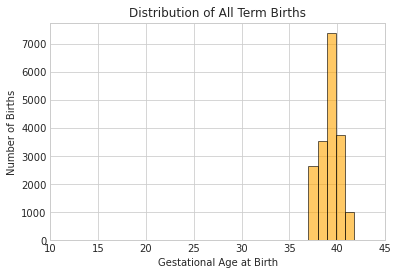

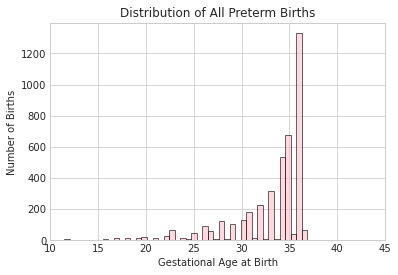

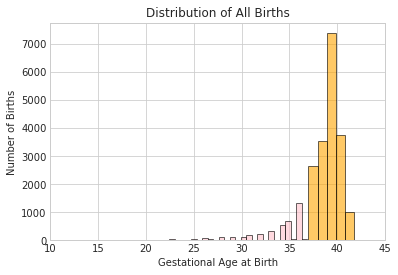

In [134]:
import matplotlib.pyplot as plt

# Filter rows with valid gestational age
valid_gestational_age_rows = df_copy.dropna(subset=['gestational_age_at_birth'])

# All Term Births
term_cases = valid_gestational_age_rows[valid_gestational_age_rows['birth_class'] == 'Term']
plt.style.use("seaborn-whitegrid")
plt.hist(term_cases['gestational_age_at_birth'], bins=300, alpha=0.6, color='orange', edgecolor='black', label='All Term')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Term Births')
plt.xlim(10, 45) 
plt.show()


# All Preterm
non_term_cases = valid_gestational_age_rows[valid_gestational_age_rows['birth_class'] != 'Term']
plt.style.use("seaborn-whitegrid")
plt.hist(non_term_cases['gestational_age_at_birth'], bins=50, alpha=0.6, color='pink', edgecolor='black', label='All Preterm')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Preterm Births')
plt.xlim(10, 45) 
plt.show()

#All Births
term_cases = valid_gestational_age_rows[valid_gestational_age_rows['birth_class'] == 'Term']
plt.style.use("seaborn-whitegrid")
plt.hist(term_cases['gestational_age_at_birth'], bins=300, alpha=0.6, color='orange', edgecolor='black', label='All Term')
plt.hist(non_term_cases['gestational_age_at_birth'], bins=50, alpha=0.6, color='pink', edgecolor='black', label='All Preterm')
plt.xlabel('Gestational Age at Birth')
plt.ylabel('Number of Births')
plt.title('Distribution of All Births')
plt.xlim(10, 45) 
plt.show()


### Basic Descriptive Statistics

In [142]:
stats = filtered_df_copy[filtered_df_copy['birth_class'] == 'Term'].describe()
print("Term")
print(stats)

stats = filtered_df_copy[filtered_df_copy['birth_class'] == 'Late Preterm'].describe()
print("Late Preterm")
print(stats)

stats = filtered_df_copy[filtered_df_copy['birth_class'] == 'Very Preterm'].describe()
print("Very Preterm")
print(stats)

stats = filtered_df_copy[filtered_df_copy['birth_class'] == 'Extremely Preterm'].describe()
print("Extremely Preterm")
print(stats)

Term
          person_id  gestational_age_at_birth  time_diff_weeks
count  1.351500e+04              13515.000000      3689.000000
mean   2.956558e+06                 38.841235       102.369825
std    2.114984e+06                  1.067597        68.270984
min    1.000131e+06                 37.000000         1.000000
25%    1.565434e+06                 38.000000        60.000000
50%    2.198153e+06                 39.000000       100.000000
75%    3.258338e+06                 40.000000       142.000000
max    9.998770e+06                 44.000000       345.000000
Late Preterm
          person_id  gestational_age_at_birth  time_diff_weeks
count  1.705000e+03               1705.000000       230.000000
mean   2.849011e+06                 34.923837        88.342857
std    1.984431e+06                  1.282666        79.308088
min    1.002347e+06                 32.000000         1.000000
25%    1.561227e+06                 34.000000         4.071429
50%    2.177847e+06                 3

## Check Preterm birth entries categorization

Double check - entries containing "preterm" from standard_concept_name should be categorized as a class of Preterm in column birth_class by our calculations.

In [112]:
#Make sure column is rounded uniformly

preterm_rows = filtered_df_copy[filtered_df_copy['standard_concept_name'].str.contains('Preterm')]
print("Number of births derived from standard_concept_name containing Preterm:", len(preterm_rows))

#Make a df of rows that have preterm in concept name but NOT preterm birth classification in birth_class
preterm_check_df = df_copy[df_copy['standard_concept_name'].str.contains(r'\bPreterm\b') & ~df_copy['birth_class'].str.contains(r'\bPreterm\b')]
print("Number of rows that have preterm in birth concept name but not preterm classification by our code:", len(preterm_check_df))

#Remove those accurately classified as preterm (< 37 weeks) according to our calculations
preterm_check_df1 = preterm_check_df.drop(preterm_check_df[preterm_check_df['gestational_age_at_birth'] < 37].index)
print("Number of rows remaining after removing those correctly classified as preterm:", len(preterm_check_df1))

#Remove rows with birth class unknown
preterm_check_df2 = preterm_check_df1.drop(preterm_check_df1[preterm_check_df1['birth_class'] == "Unknown"].index)
print("Number of rows remaining after removing those with birth class Unknown:", len(preterm_check_df2))

preterm_check_df3 = preterm_check_df2.drop(preterm_check_df2[preterm_check_df2['gestational_age_at_birth'] > 45].index)
print("Entries with conflict between 'preterm' birth concept and birth_class <= 45 weeks of age", len(preterm_check_df3))

print("Unique entries of gestational ages at birth between 37 and 45 weeks", preterm_check_df3['gestational_age_at_birth'].unique())





Number of births derived from standard_concept_name containing Preterm: 1116
Number of rows that have preterm in birth concept name but not preterm classification by our code: 95
Number of rows remaining after removing those correctly classified as preterm: 95
Number of rows remaining after removing those with birth class Unknown: 95
Entries with conflict between 'preterm' birth concept and birth_class <= 45 weeks of age 72
Unique entries of gestational ages at birth between 37 and 45 weeks [37.         38.         37.71428571 38.57142857 39.28571429 40.
 39.         43.71428571 43.85714286 41.28571429 41.         37.28571429
 38.28571429 38.14285714 38.42857143 38.85714286]


### Look at instances of person_id to determine why there might be a classification mismatch - DECISION NEEDED

A few spot checks show that our conception calculation was pulled from "Gestation period, 37 weeks" for example, and then the following birth was labeled a preterm birth. This is for 0.3% of the dataset so most likley a recording error. I conferred with an OB/GYN who said it was likely an error as 37 weeks and over is considered term. 

I did (on accident) find a case where one of the medical records was an error. (See below). I'm not sure how to treat this. Can sort by condition_start_datetime to try to catch most recent medical entry only.

Options:
- Drop all mismatches between 37 and 45 weeks (greater than 45 will be dropped because of earlier max allowance)
- Keep classification via our code rather than birth concept label

In [125]:
#Seems to be entry error; true 37 weeks
person_check = df_copy[df_copy['person_id'] == 1094374]
person_check

#Seems to be entry error; true 37 weeks
person_check = df_copy[df_copy['person_id'] == 9434919]
person_check

#This person has an error in their entry, true 34 weeks. I'm not sure how to easily correct this... It seems that their second appointment
#they updated gestational age (3 weeks younger) and maybe made an error when entering at birth. 
person_check = df_copy[df_copy['person_id'] == 1082329]
person_check


,person_id,standard_concept_name,condition_start_datetime,condition_start_date,condition_end_date,conception_date,gestational_age_at_birth
18420,1082329,"Gestation period, 11 weeks",2020-01-28 15:09:00+00:00,2020-01-28,2020-02-13,2019-11-12,NaN
295441,1082329,"Gestation period, 8 weeks",2020-02-03 18:34:00+00:00,2020-02-03,2020-02-04,2019-12-09,NaN
21214,1082329,"Gestation period, 11 weeks",2020-02-13 05:00:00+00:00,2020-02-13,2020-02-13,2019-11-28,NaN
1961,1082329,"Gestation period, 18 weeks",2020-03-30 04:00:00+00:00,2020-03-30,2020-03-30,2019-11-25,NaN
118505,1082329,"Gestation period, 21 weeks",2020-03-30 18:56:00+00:00,2020-03-30,2020-04-20,2019-11-04,NaN
118725,1082329,"Gestation period, 21 weeks",2020-04-20 04:00:00+00:00,2020-04-20,2020-04-20,2019-11-25,NaN
50759,1082329,"Gestation period, 25 weeks",2020-05-15 04:00:00+00:00,2020-05-15,2020-05-15,2019-11-22,NaN
50729,1082329,"Gestation period, 25 weeks",2020-05-19 04:00:00+00:00,2020-05-19,2020-05-19,2019-11-26,NaN
40793,1082329,"Gestation period, 27 weeks",2020-05-29 04:00:00+00:00,2020-05-29,2020-05-29,2019-11-22,NaN
108709,1082329,"Gestation period, 29 weeks",2020-06-15 04:00:00+00:00,2020-06-15,2020-06-15,2019-11-25,NaN


# Debugging

The cells below were used for debugging.

In [ ]:
#Troubleshooting
#the list appears correct and in correct order
#print(gest_test)

#All conception_date values are correctly formatted.
#try:
    #pd.to_datetime(df['conception_date'], errors='raise')
    #print("All values in the 'conception_date' column are valid dates.")
#except ValueError:
    #print("There are non-date values in the 'conception_date' column.")
    
#Debugged with 1000195 (for gestation periods being used in correct order of priority)    
#Create mini dataset only person  
#df = date_only_long_data_no_triple_duplicates.copy()
#df = df.sort_values(by=['person_id', 'condition_start_date'])

#person_df = df[df['person_id'] == 1001211]
#person_df

#person_df = person_df.reset_index(drop=True)
#df = person_df

# Initialize variables to store the most recent "Gestation period" and birth dates
#most_accurate_conception_date = None
#birth_dates = []

# Initialize gest_test as an empty list
#gest_test = []

# Initialize current_person_id
#current_person_id = None

# Iterate through the DataFrame
#for idx, row in df.iterrows():
 #   if row['person_id'] != current_person_id:
        # Update the current person_id
  #      current_person_id = row['person_id']
   #     most_accurate_conception_date = None  # Reset for the new person_id

        # Create a dynamic gest_test list based on the unique values in standard_concept_name
        # Scan all rows for the current person_id and update gest_test
    #    gest_test = df[df['person_id'] == current_person_id]['standard_concept_name'].unique()

    # Print the current row information
    #print(f"Examining row {idx}, person_id: {row['person_id']}, standard_concept_name: {row['standard_concept_name']}")

    #for test_period in gest_test:
        # Check if the row matches the current gest_test item
     #   if row['standard_concept_name'] == test_period:
      #      most_accurate_conception_date = row['conception_date']
       #     print(f"Assigned most_accurate_conception_date: {most_accurate_conception_date}")

#    if 'gestational_age_at_birth' not in df.columns:
 #       df['gestational_age_at_birth'] = np.nan
  #      print("Created gestational_age_at_birth column")

   # if row['standard_concept_name'] == 'Single live birth' and pd.isna(df.at[idx, 'gestational_age_at_birth']):
    #    birth_dates.append((idx, row['condition_start_date']))

     #   if most_accurate_conception_date is not None:
      #      last_idx, last_birth_date = birth_dates[-1]
       #     gestational_age = (pd.to_datetime(last_birth_date) - pd.to_datetime(most_accurate_conception_date)).days / 7
        #    df.at[last_idx, 'gestational_age_at_birth'] = gestational_age
         #   most_accurate_conception_date = None  # Reset date after calculating gestational age
          #  print(f"Calculated gestational age: {gestational_age}")

#df